# Catching asteroids and tracking satellites with Python

![Groundtrack](img/groundtrack.png)

### Juan Luis Cano // 2017-12-20 PyBCN @ Skyscanner

# Outline

1. Who am I?
2. ~~How come those things never fall?~~ Quick intro to Orbital Mechanics
3. orbit-predictor & poliastro
4. Challenges in writing performant, high level Python
5. Conclusions

# 1. Who am I?

<img src="img/juanlu_esa.jpg" alt="Me!" width="400" style="float:right"></img>

* **Aerospace Engineer** with a passion for orbits 🛰
* Chair of the **Python España** non profit and co-organizer of **PyCon Spain** 🐍
  - Come to Málaga next year!
* **Software Developer** at **Satellogic** 🌍
  - We're hiring!
* Free Software advocate and Python enthusiast 🕮
* Hard Rock lover 🎸

Follow me! https://github.com/Juanlu001/ ([🔝10 GitHub Spain by followers!](https://rawgit.com/RDCH106/ghrankings-viewer/master/ghrankings-viewer.html))

<div style="clear:both"></div>

## What is this talk about?

> Showing orbit-predictor and poliastro, explaining what they do, and which challenges does developing scientific libraries present.

No rocket science! Well... A little bit

# 2. Quick intro to Orbital Mechanics

### Physics → Mechanics → Celestial Mechanics → Orbital Mechanics

> A branch of Mechanics (itself a branch of Physics) that studies practical problems regarding the motion of rockets and other human-made objects through space

![Milanesat](img/milanesat.jpg)

## But why do bodies orbit?

The long explanation for another day :) As a summary, let's visualize this experiment imagined by Newton:

<img src="img/newtons-cannonball.jpg" alt="Newton" width="400" ></img>

## If it's so simple, why all the fuss?

* Difficult to measure: these things move at around ~8 000 meters per second (Barcelona-Madrid in one minute) and GPS precision is not that good
* ...But great accuracy is required: we want to take pictures of specific places from 700 kilometers distance!
* Many perturbations: the Earth is not a sphere, the Moon is very close, the sunlight pushes the satellite (yes!)...
* If you lose contact with the satellite, it's a needle in a haystack

![Debris](img/debris.gif)

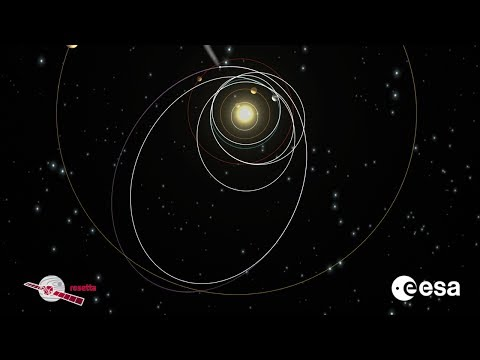

In [1]:
from IPython.display import YouTubeVideo
YouTubeVideo("iEQuE5N3rwQ", width=800, height=600)

# orbit-predictor

> orbit-predictor is a Python library to propagate orbits of Earth-orbiting objects (satellites, ISS, Santa Claus, etc) using TLE (Two-Line Elements sets)

* **Pure Python** and **MIT license** (permissive)
* Several TLE sources: disk, memory, network, our APIs
* Many predictors: quick, precise, analytical (Keplerian-only and J2)
* Open sourced by Satellogic, contributors welcome!

### Setting everything up

In [2]:
from orbit_predictor.sources import NoradTLESource

source = NoradTLESource.from_url("http://www.celestrak.com/NORAD/elements/resource.txt")

In [3]:
predictor = source.get_predictor("NUSAT-3")

In [4]:
from orbit_predictor.locations import Location

FBR = Location("Observatori Fabra", 41.4184, 2.1239, 408)

### Get next pass over location

In [5]:
predicted_pass = predictor.get_next_pass(FBR)
predicted_pass

<PredictedPass NUSAT-3 over Observatori Fabra on 2017-12-20 18:57:44.731958>

In [6]:
predicted_pass.aos  # Acquisition Of Signal

datetime.datetime(2017, 12, 20, 18, 57, 44, 731958)

In [7]:
predicted_pass.duration_s

660.0

In [8]:
predictor.get_position(predicted_pass.aos).position_llh

(20.801307810843326, -7.256839023469308, 535.3917288158164)

### Plot groundtrack

In [9]:
import matplotlib.pyplot as plt
plt.ion()

import cartopy.crs as ccrs

import pandas as pd

In [10]:
dates = pd.date_range(start="2017-12-11 00:00", periods=1000, freq="30S")

In [11]:
latlon = pd.DataFrame(index=dates, columns=["lat", "lon"])

for date in dates:
    lat, lon, _ = predictor.get_position(date).position_llh
    latlon.loc[date] = (lat, lon)

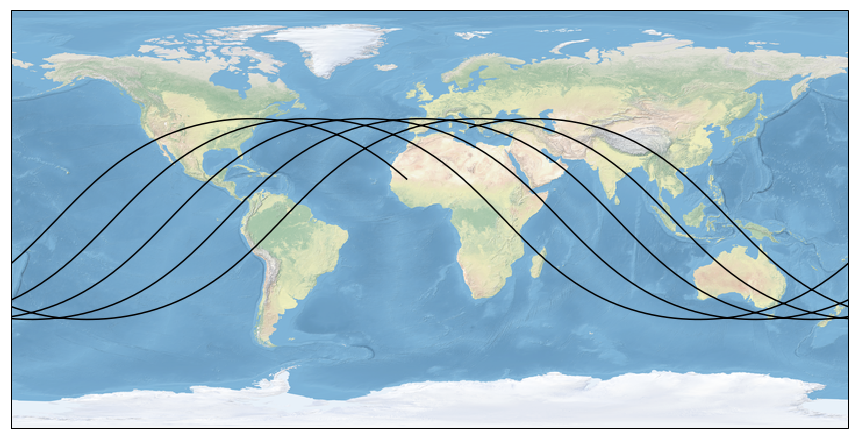

In [12]:
plt.figure(figsize=(15, 25))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.stock_img()

plt.plot(latlon["lon"], latlon["lat"], 'k',
         transform=ccrs.Geodetic());

# poliastro

<img src="img/logo_text.svg" alt="poliastro" width="500" style="float:right"></img>

[Summary here]

* **Pure Python**, accelerated with **numba** (~same order of magnitude as Fortran)
* **MIT license** (permissive)
* Physical units, astronomical scales and more, thanks to Astropy
* Conversion between several orbit representations
* Analytical and numerical propagation
* Cool documentation 🚀 http://docs.poliastro.space/
* Latest version 0.8.0 released a month ago http://docs.poliastro.space/en/v0.8.0/changelog.html#poliastro-0-8-0-2017-11-18

<div style="clear:both"></div>

In [20]:
import matplotlib.pyplot as plt
plt.ion()

from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)

from astropy import units as u
from astropy.time import Time

from poliastro.bodies import Earth
from poliastro.twobody import Orbit
from poliastro.plotting import plot, plot3d, OrbitPlotter

## _Interlude: Time zones? Hold my beer_

![Time scales](img/time_scales.png)

## First contact

* Interactive usage on Jupyter notebook
* Physical units, astronomical time scales and reference frame handling (thanks to Astropy)
* Orbital elements conversion (cartesian, keplerian, equinoctial)
* 2D and 3D visualization

In [36]:
r = [-6045, -3490, 2500] * u.km
v = [-3.457, 6.618, 2.533] * u.km / u.s

ss = Orbit.from_vectors(Earth, r, v, Time.now())
ss

7283 x 10293 km x 153.2 deg orbit around Earth (♁)

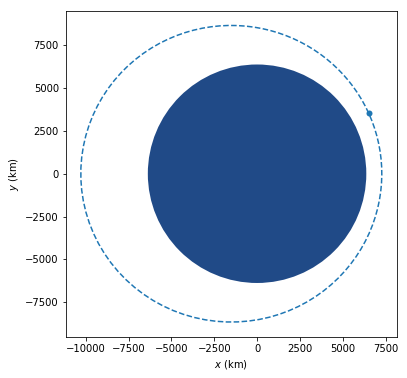

In [37]:
plot(ss);

In [38]:
plot3d(ss, label="Sample orbit");

## External data

* Planetary ephemerides
  - SPICE kernels
* Near Earth Objects (NEOs)
  - NeoWs https://api.nasa.gov/neo/?api_key=DEMO_KEY
  - DASTCOM5 database ftp://ssd.jpl.nasa.gov/pub/ssd/README.txt

In [ ]:
from astropy.coordinates import solar_system_ephemeris
solar_system_ephemeris.set("jpl")

In [39]:
Orbit.from_body_ephem(Earth)

1 x 1 AU x 23.4 deg orbit around Sun (☉)

In [40]:
from poliastro.neos import neows

florence = neows.orbit_from_name("Florence")
florence

1 x 3 AU x 22.2 deg orbit around Sun (☉)

In [41]:
from poliastro.neos import dastcom5

halley_1835 = dastcom5.orbit_from_name('1P')[30]
halley_1835

1 x 35 AU x 162.3 deg orbit around Sun (☉)

(-300000000.0, 300000000.0)

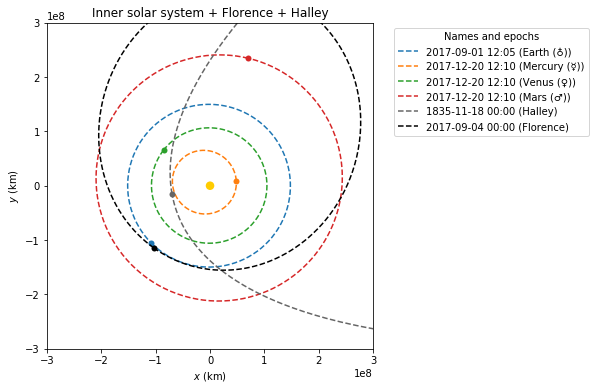

In [42]:
from poliastro.plotting import OrbitPlotter
from poliastro.bodies import Mercury, Venus, Earth, Mars

frame = OrbitPlotter(num_points=300)

# Florence close approach
frame.plot(Orbit.from_body_ephem(Earth, epoch=Time("2017-09-01 12:05:50", scale="tdb")), label=Earth)

for planet in Mercury, Venus, Mars:
    frame.plot(Orbit.from_body_ephem(planet), label=planet)

frame.plot(halley_1835, label='Halley', color='#666666')
frame.plot(florence, label='Florence', color='#000000')

plt.title("Inner solar system + Florence + Halley")
plt.xlim(-.3e9, .3e9)
plt.ylim(-.3e9, .3e9)

### NEOWS API

It's based on this [NASA API](https://api.nasa.gov/api.html#NeoWS).

![Interfaz web NEOWS](img/interfaz_neows.png)

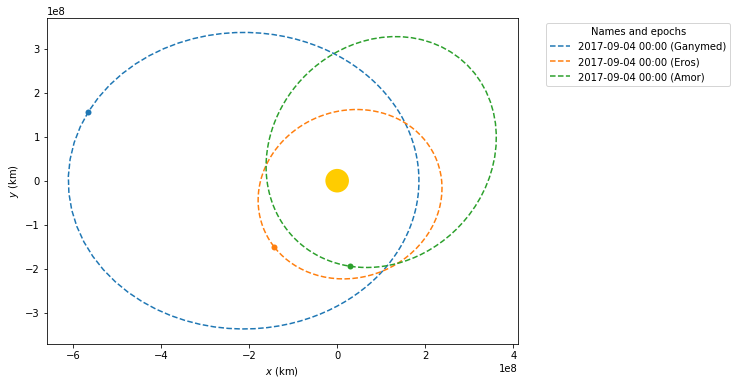

In [6]:
eros = neows.orbit_from_name('Eros')
ganymed = neows.orbit_from_name('1036') # Ganymed IAU number
amor = neows.orbit_from_name('2001221') # Amor SPK-ID

frame = OrbitPlotter(num_points=300)
frame.plot(ganymed, label='Ganymed')
frame.plot(eros, label='Eros')
frame.plot(amor, label='Amor')

### How does it work?

![SBDB](img/sbdb.png)

### DASTCOM5 module

Works with the DASTCOM5, maintained by NASA and JPL. Contains data on comets and asteroids.

The dayabase comes in a ~230 MB zip that can be downloaded [by hand](ftp://ssd.jpl.nasa.gov/pub/ssd/dastcom5.zip) or using this poliastro function:

```python
dastcom5.download_dastcom5()
```

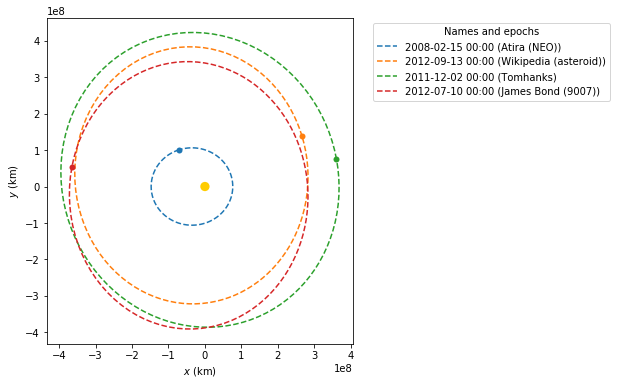

In [8]:
atira = dastcom5.orbit_from_name('atira')[0] # NEO
wikipedia = dastcom5.orbit_from_name('wikipedia')[0] # Asteroid, but not NEO.
tomhanks = dastcom5.orbit_from_name('tomhanks')[0]
jamesbond = dastcom5.orbit_from_name('9007')[0]

frame = OrbitPlotter()
frame.plot(atira, label='Atira (NEO)')
frame.plot(wikipedia, label='Wikipedia (asteroid)')
frame.plot(tomhanks, label='Tomhanks')
frame.plot(jamesbond, label='James Bond (9007)');

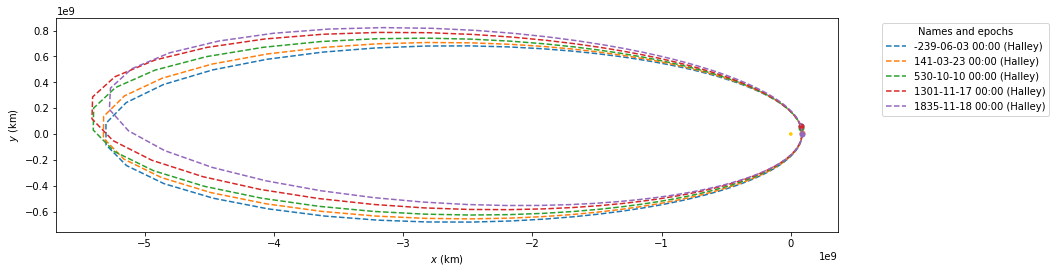

In [54]:
halleys = dastcom5.orbit_from_name('1P')

frame = OrbitPlotter(num_points=200)
frame.plot(halleys[0], label='Halley')
frame.plot(halleys[5], label='Halley')
frame.plot(halleys[10], label='Halley')
frame.plot(halleys[20], label='Halley')
frame.plot(halleys[30], label='Halley')

### How does it work?

![dastcom5 index](img/dastcom5_index.png)

![DASTCOM5 structure](img/dastcom5_structure.png)

![Asteroid and comet structure](img/ast_com_structure.png)

In [55]:
ast_db = dastcom5.asteroid_db()
comet_db = dastcom5.comet_db()

ast_db.dtype.names[:20] # They are more than 100, but that would be too much lines in this notebook :P

('NO',
 'NOBS',
 'OBSFRST',
 'OBSLAST',
 'EPOCH',
 'CALEPO',
 'MA',
 'W',
 'OM',
 'IN',
 'EC',
 'A',
 'QR',
 'TP',
 'TPCAL',
 'TPFRAC',
 'SOLDAT',
 'SRC1',
 'SRC2',
 'SRC3')

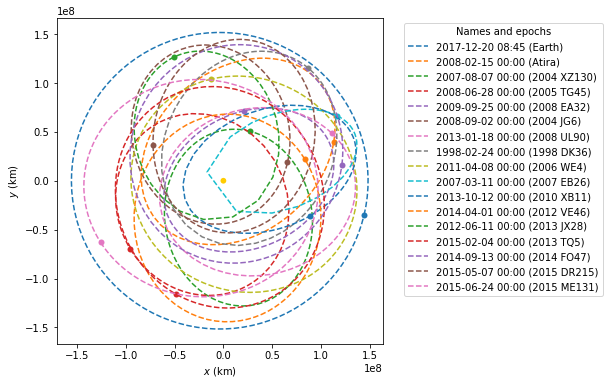

In [56]:
aphelion_condition = 2 * ast_db['A'] - ast_db['QR'] < 0.983
axis_condition = ast_db['A'] < 1.3 
atiras = ast_db[aphelion_condition & axis_condition]

earth = Orbit.from_body_ephem(Earth)

frame = OrbitPlotter()
frame.plot(earth, label='Earth')

for i in range(len(atiras)):
    record = atiras['NO'][i]
    label = atiras['ASTNAM'][i].decode().strip()  # DASTCOM5 strings are binary
    ss = dastcom5.orbit_from_record(record)
    frame.plot(ss, label=label)

In [57]:
db = dastcom5.entire_db()

db[db.NAME == 'Churyumov-Gerasimenko']

,NUMBER,NOBS,OBSFRST,OBSLAST,EPOCH,CALEPOCH,MA,W,OM,IN,EC,A,QR,TP,TPCAL,TPFRAC,SOLDAT,DESIG,IREF,NAME
740310,900667,1154,0,0,2440480.5,19690916.0,0.746918,11.246300,51.011000,7.149400,0.633017,3.501429,1.284965,2.440476e+06,1.969091e+07,0.534800,0.000000e+00,67P,SAO/1969,Churyumov-Gerasimenko
740311,900668,1154,0,0,2442880.5,19760412.0,0.713185,11.358700,51.028400,7.128900,0.630558,3.514828,1.298525,2.442876e+06,1.976041e+07,0.731800,0.000000e+00,67P,SAO/1976,Churyumov-Gerasimenko
740312,900669,1154,0,0,2445280.5,19821107.0,359.239635,11.366700,51.015300,7.117000,0.629152,3.522047,1.306144,2.445286e+06,1.982111e+07,0.599300,0.000000e+00,67P,SAO/1982,Churyumov-Gerasimenko
740313,900670,1154,0,0,2447680.5,19890603.0,357.698070,11.424500,51.011500,7.118300,0.630254,3.515073,1.299684,2.447696e+06,1.989062e+07,0.891800,0.000000e+00,67P,SAO/1989,Churyumov-Gerasimenko
740314,900671,1154,0,0,2450080.5,19951229.0,357.060788,11.386100,51.007000,7.113500,0.630193,3.515434,1.300032,2.450100e+06,1.996012e+07,0.156000,0.000000e+00,67P,SAO/1996,Churyumov-Gerasimenko
740315,900672,1154,0,0,2452520.5,20020903.0,2.354453,11.451400,50.969300,7.120500,0.631529,3.507299,1.292338,2.452505e+06,2.002082e+07,0.809200,0.000000e+00,67P,SAO/2002,Churyumov-Gerasimenko
740316,900673,6325,19950703,20170427,2455491.5,20101022.0,91.768086,12.694464,50.180046,7.043681,0.640582,3.464738,1.245288,2.454891e+06,2.009023e+07,0.027525,2.457882e+06,67P,K154/1,Churyumov-Gerasimenko


# 4. Challenges

## Validation

> Unit testing a function with clear expectations is trivial. What are my expectations on numerical algorithms?

The wrooooooooooooooong way:

In [27]:
def sinc(x):
    return np.sin(x) / x

In [28]:
import pytest

In [31]:
@pytest.mark.parametrize("x", [0, 1, 10])
def test_sinc(x):
    assert sinc(x) == np.sin(x) / x

In [32]:
0.1 + 0.2 == 0.3

False

In [33]:
0.2 + 0.3 == 0.5

True

What's the good way?

* Doing floating point comparisons right is only the first step: you have to **validate against external data or software**
* How much precision do you ask for?
* The changes in precision are a result of bad data, worse algorithms? How do you even track _improvements_?

### External data (short summary)

* Nobody cares

* Those who care, don't share it

* Those who share, do it with 1 decimal place (true story)

* Those who share with 16 decimal places, don't describe how it was obtained (i.e. release the source)

* Those who release the source, make it impossible to compile

### External software

* Sometimes commercial
* Is it validated itself? (See above)
* It is often difficult to reproduce the exact setting and algorithms, most of the times because your commercial software is much more complex

![Shrug](img/shrugging-guy.jpg)

...Or, if you're really interested, go read my Final Masters Project: https://github.com/juanlu001/pfc-uc3m

## Performant and "for humans"

* _Yes, Python is slow_ (compared to compiled languages)
* Some algorithms cannot easily be vectorized (i.e. replaced by NumPy)
* And even if you can, vectorized code can be impossible to read
* I don't like Cython (messy, impossible to debug, I don't know C)
* _numba only helps only with Fortran-esque code_ (forget about closures or introspection)

![Too smart](img/too_smart.png)

## Is it that bad?

<img src="img/mco.png" alt="Mars Climate Orbiter" width="400" ></img>

<img src="img/architecture.svg" alt="Architecture" width="400" style="float:right"></img>

So... let's make our code Fortran-esque!

High level API:

* Supports mixed units and time scales, figures out the rest
* Easy to use and impossible to get wrong
* **Slow**

Dangerous™ algorithms:

* **Fast** (easy to accelerate with numba or Cython)
* Only cares about numbers, makes assumptions on units (SI, TBD)
* **You can mess it up**

<div style="clear:both"></div>

## Community building

> I believe the choice of license is an important one, and I advocate a BSD-style license. **In my experience, the most important commodity an open source project needs to succeed is users.**
>
> -- John Hunter † http://nipy.org/nipy/faq/johns_bsd_pitch.html

* Sometimes, language wins over performance
* Sometimes, documentation wins over features
* Sometimes, marketing wins over quality

_Go find your users!_

![Success story](img/success_story.png)

http://docs.poliastro.space/en/latest/#success-stories

## Conclusions

* You can track satellites and catch asteroids in Python from home :)
* Providing a friendly API is key, even for scientific libraries
* Validation is a hard problem
* Community building is a difficult, yet rewarding experience

# _Per Python ad astra!_

* Slides: https://github.com/poliastro/pycones2017-talk
* poliastro chat: https://riot.im/app/#/room/#poliastro:matrix.org
* Jobs @ Satellogic: https://boards.greenhouse.io/satellogic

## Muchas gracias :)

![Rocket](img/rocket.jpg)